# Creating Customer Segments

In this project you, will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

In [199]:
# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import math 
import matplotlib 
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

# Tell iPython to include plots inline in the notebook
%matplotlib inline

# Read dataset
data = pd.read_csv("wholesale-customers.csv")
print "Dataset has {} rows, {} columns".format(*data.shape)
print data.head()  # print the first 5 rows

Dataset has 440 rows, 6 columns
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  12669  9656     7561     214              2674          1338
1   7057  9810     9568    1762              3293          1776
2   6353  8808     7684    2405              3516          7844
3  13265  1196     4221    6404               507          1788
4  22615  5410     7198    3915              1777          5185


## Quick exploratory analysis 

### Summary Statistics

In [18]:
data.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Histograms

The summary statistics above suggest a long tail in the distribution across all variables, which is common in purchase dollar data. The histograms in red below confirmed that this is the case. 

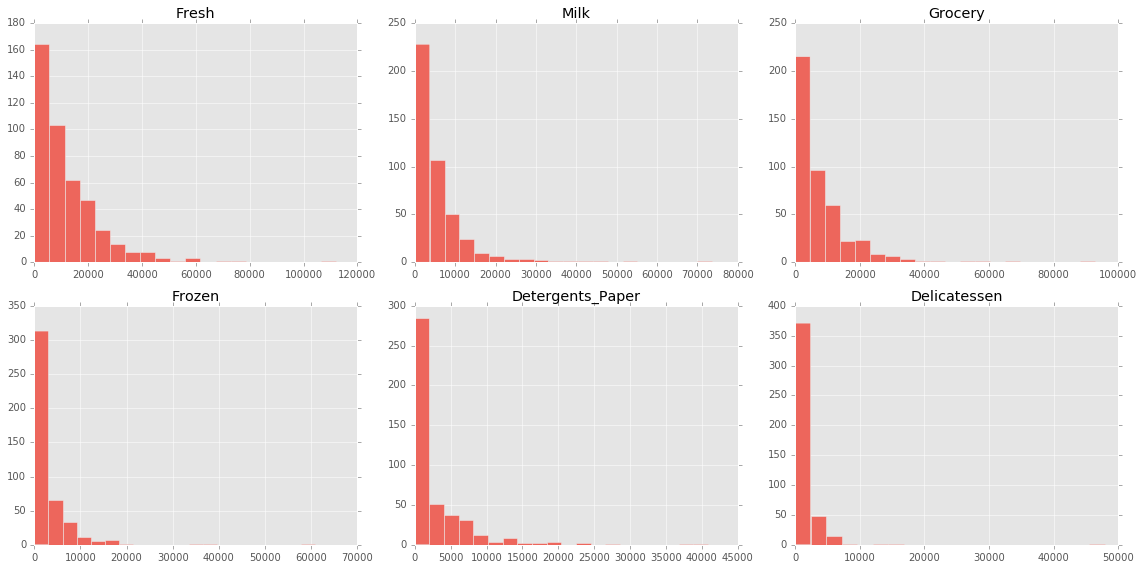

In [195]:
plt.figure(figsize=(16,8))

for i, j in zip(range(6), data.columns):
    plot_no = 231 + i 
    plt.subplot(plot_no)
    plt.hist(data[j], bins=20, color = (0.93,0.4,0.36))
    plt.title(j)

plt.tight_layout()

### Log transformation 

Moreover, even though the variables are on the same scale (i.e. monetary units), the largest variable 'Fresh' is almost one order of magnitude larger than the smallest variable 'Delicatessen' in mean values. While the disparity is not nearly large enough to mandate standardization of variables, we should consider some form of data transformation. In this case, we will perform a log transformation, which not only helps normalize our data, but also bring the values within a closer scale. The histograms below in blue show the transformed data. 

In [196]:
data_log = np.log(data)
df = pd.DataFrame(data_log, columns = data.columns)
df.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,9.446913,9.175335,8.930759,5.365976,7.891331,7.198931
1,8.861775,9.191158,9.166179,7.474205,8.099554,7.482119
2,8.756682,9.083416,8.946896,7.785305,8.165079,8.967504
3,9.492884,7.086738,8.347827,8.764678,6.228511,7.488853
4,10.026369,8.596004,8.881558,8.272571,7.482682,8.553525


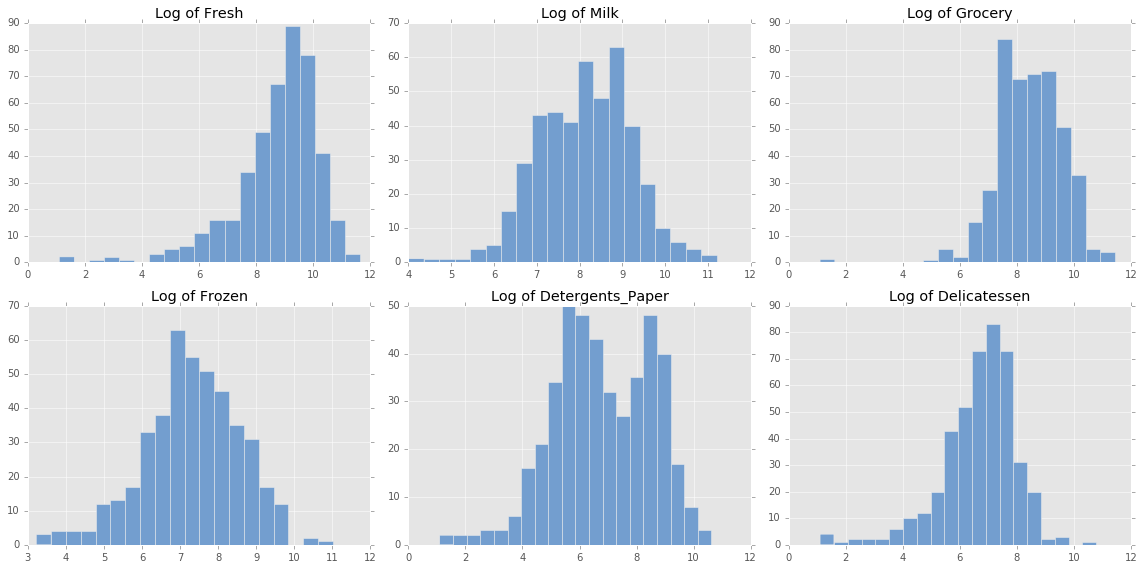

In [197]:
plt.figure(figsize=(16,8))

for i, j in zip(range(6), df.columns):
    plot_no = 231 + i 
    plt.subplot(plot_no)
    plt.hist(df[j], bins=20, color = (0.45,0.62,0.81))
    plt.title('Log of '+ j)

plt.tight_layout()

### Scatterplot and Correlation Matrix

The scatterplot matrix below shows the relationship between each pair of variables. Many variables appear correlated, particularly 'Milk', 'Grocery, and 'Detergents_Paper'.

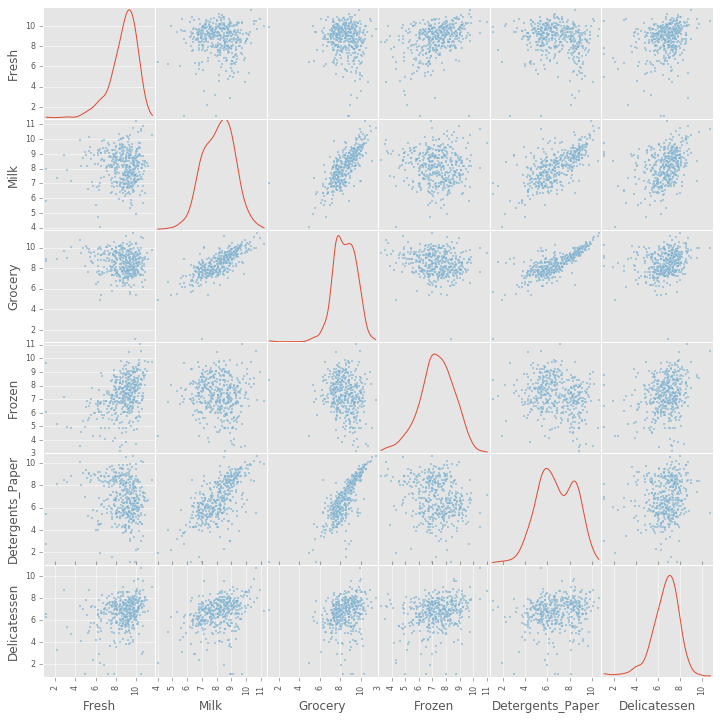

In [201]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(data_log, alpha=.5, figsize=(12, 12), diagonal='kde');

To observe the relationships more precisely, we compute the correlation matrix below. 'Grocery', 'Milk', and 'Detergents_Paper' do indeed have very high pair-wise correlations (all above 0.67). In addition, 'Frozen' and 'Fresh' also have a decently high correlation of 0.38. 'Delicatessen', on the other hand, is weakly correlated with all other items perhaps with the exception of 'Detergents_Paper'. 

In [203]:
df.corr()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Fresh,1.000000,-0.019834,-0.132713,0.383996,-0.155871,0.255186
Milk,-0.019834,1.000000,0.758851,-0.055316,0.677942,0.337833
Grocery,-0.132713,0.758851,1.000000,-0.164524,0.796398,0.235728
Frozen,0.383996,-0.055316,-0.164524,1.000000,-0.211576,0.254718
Detergents_Paper,-0.155871,0.677942,0.796398,-0.211576,1.000000,0.166735
Delicatessen,0.255186,0.337833,0.235728,0.254718,0.166735,1.000000


## Feature Transformation

**1)** In this section you will be using PCA and ICA to start to understand the structure of the data. Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.

Answer: Based on our exploratory analysis above, I would guess the first PCA/ICA dimension could be a catch-all term for 'Grocery', 'Milk', and 'Detergents_Paper', which as previously noted, had very high pair-wise correlations. These are likely long shelf-life items that grocery or convenience stores. Another dimension could be a catch-all term for 'Fresh' and 'Frozen' items that also have moderately high correlation. These are highly perishable goods that restaurants or supermarkets are more likely to purchase. Another likely PCA/ICA component could simply be an aggregate of all six purchase categories, a signal of each customer's business scale. 

### PCA

In [209]:
# TODO: Apply PCA with the same number of dimensions as variables in the dataset
from sklearn.decomposition import PCA
pca_full = PCA(n_components=6)
pca_full.fit(df)

# Print the components and the amount of variance in the data contained in each dimension
print "The PCA components are:"
print pd.DataFrame(pca.components_, columns=df.columns, index=range(1,7)) 
print ""
print "The explained variance ratios are:"
print pca.explained_variance_ratio_

The PCA components are:
      Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicatessen
1 -0.173717  0.394463  0.454364 -0.172196          0.745515      0.149436
2  0.685136  0.162399  0.069379  0.487691          0.041912      0.509709
3  0.673512 -0.033068  0.032183 -0.284811          0.218244     -0.644597
4 -0.214326  0.018558  0.064487  0.806083          0.190050     -0.513490
5  0.000822 -0.722288 -0.347993  0.036243          0.563665      0.195366
6  0.029276 -0.543035  0.813908  0.017448         -0.202444      0.022832

The explained variance ratios are:
[ 0.44237417  0.27657107  0.11617342  0.09617719  0.0457568   0.02294735]


**2)** How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?

Answer: The majority of the variance is captured by the first two PCA components, accounting for 44% and 28% of the variance respectively. There is a significant drop off after these two components, although the third and fourth PCA components still account for a respectable 12% and 10% variance respectively. This is a relatively tough call: if I were interested in using the PCA components for prediction afterward, I am inclined to include up to 4 dimensions to retain at least 90% of the variance/information. However, during an exploratory analysis stage, I would choose N=2 dimensions for sake of simplicity and ease of interpretation through graphical plots. 

**3)** What do the dimensions seem to represent? How can you use this information?

Answer: As predicted earlier, the first PCA component does appear to be a catch-all term for long shelf-life goods like 'Milk', 'Grocery', and 'Detergents_Paper' that grocery and convenience stores are likely to purchase. The second PCA component, on the other hand, represents more perishable goods like 'Fresh', 'Frozen', and 'Delicatessen'. This information a


The first dimension indeed appears to be a catch-all term for the three highly-correlated purchase categories of "milk", "grocery", and "detergents_paper" as discussed earlier. On the other hand, the second component appears to be a catch-all term for the other three categories. This information allows us to reduce the dimension of our dataset, aggregating all the purchase data into two umbrella categories, which in turn allows us to visualize the dataset with our naked eye (which is exceptionally good at recognizing patterns and clusters). 

### ICA

In [188]:
# TODO: Fit an ICA model to the data
# Note: Adjust the data to have center at the origin first!

from sklearn.preprocessing import scale 
from sklearn.decomposition import FastICA

data_scaled = pd.DataFrame(scale(data), columns = data.columns)
ica = FastICA(n_components=2)
ica.fit(data_scaled)

# Print the independent components
print ica.components_
df_ica = pd.DataFrame(ica.components_, columns=data.columns)
df_ica

[[ 0.00377656 -0.01464876 -0.01778265  0.00432933 -0.01794756 -0.00227488]
 [ 0.01895686  0.00706967 -0.00076222  0.02196124 -0.00484634  0.01968047]]


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,0.003777,-0.014649,-0.017783,0.004329,-0.017948,-0.002275
1,0.018957,0.007070,-0.000762,0.021961,-0.004846,0.019680


**4)** For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?

Answer: 

## Clustering

In this section you will choose either K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then you will sample elements from the clusters to understand their significance.

### Choose a Cluster Type

**5)** What are the advantages of using K Means clustering or Gaussian Mixture Models?

Answer: 

**6)** Below is some starter code to help you visualize some cluster data. The visualization is based on [this demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) from the sklearn documentation.

In [85]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

In [173]:
# TODO: First we reduce the data to two dimensions using PCA to capture variation
reduced_fit = PCA(n_components=2)
reduced_data = reduced_fit.fit_transform(data_scaled)
print reduced_data[:10]  # print upto 10 elements

[[-0.19329055  0.30509996]
 [-0.4344199   0.32841262]
 [-0.81114323 -0.8150957 ]
 [ 0.77864783 -0.65275373]
 [-0.16628726 -1.27143372]
 [ 0.15616993  0.29514099]
 [ 0.3352884   0.52500326]
 [-0.14058643  0.23099269]
 [ 0.51731954  0.65936283]
 [-1.59210908  0.74101133]]


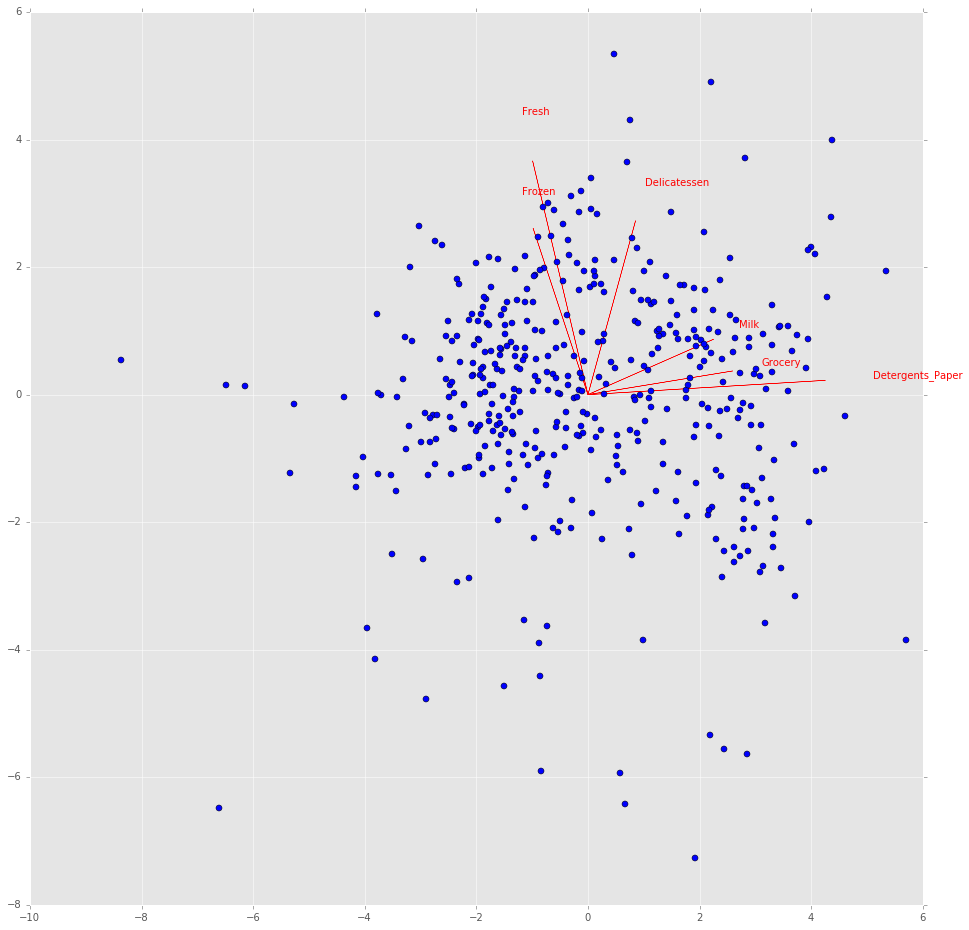

In [194]:
## perform PCA

# n = len(data_scaled.columns)

pca = PCA(n_components = 2)
# defaults number of PCs to number of columns in imported data (ie number of
# features), but can be set to any integer less than or equal to that value

pca.fit(data_log)

## project data into PC space

# 0,1 denote PC1 and PC2; change values for other PCs
xvector = pca.components_[0] # see 'prcomp(my_data)$rotation' in R
yvector = pca.components_[1]

xs = pca.transform(data_log)[:,0] # see 'prcomp(my_data)$x' in R
ys = pca.transform(data_log)[:,1]

## visualize projections
    
## Note: scale values for arrows and text are a bit inelegant as of now,
##       so feel free to play around with them

plt.figure(figsize=(16,16))

for i in range(len(xvector)):
# arrows project features (ie columns from csv) as vectors onto PC axes
    plt.arrow(0, 0, xvector[i]*max(xs), yvector[i]*max(ys),
              color='r', width=0.0005, head_width=0.0025)
    plt.text(xvector[i]*max(xs)*1.2, yvector[i]*max(ys)*1.2,
             list(data_scaled.columns.values)[i], color='r')

for i in range(len(xs)):
# circles project documents (ie rows from csv) as points onto PC axes
    plt.plot(xs[i], ys[i], 'bo')
#    plt.text(xs[i]*1.2, ys[i]*1.2, list(data_scaled.index)[i], color='b')

plt.show()

In [174]:
# TODO: Implement your clustering algorithm here, and fit it to the reduced data for visualization
# The visualizer below assumes your clustering object is named 'clusters'
kmeans = KMeans(init='k-means++', n_clusters=2, n_init=10)
kmeans.fit(reduced_data)
print kmeans

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)


In [175]:
# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

In [176]:
# TODO: Find the centroids for KMeans or the cluster means for GMM 

centroids = kmeans.cluster_centers_
print centroids

[[-3.67428358  0.40751388]
 [ 0.41858927 -0.04642563]]


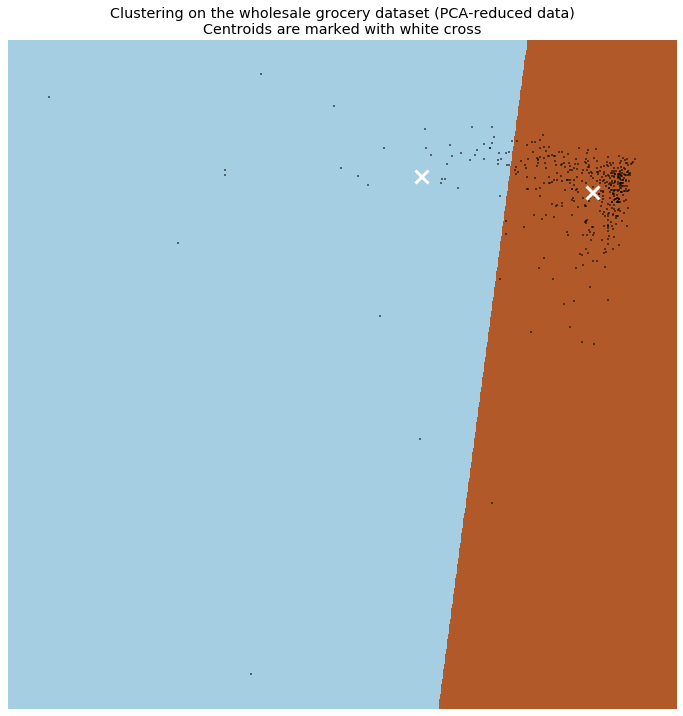

In [180]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12,12))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

**7)** What are the central objects in each cluster? Describe them as customers.

In [178]:
centroids_inverse = pca.inverse_transform(centroids)
print centroids_inverse
pd.DataFrame(centroids_inverse, columns=data.columns)

[[-0.05757185  1.96902732  2.18788507 -0.06102273  2.11987072  0.70825675]
 [ 0.00655882 -0.22431957 -0.24925273  0.00695196 -0.24150426 -0.08068748]]


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,-0.057572,1.969027,2.187885,-0.061023,2.119871,0.708257
1,0.006559,-0.224320,-0.249253,0.006952,-0.241504,-0.080687


Answer: 

###Conclusions

** 8)** Which of these techniques did you feel gave you the most insight into the data?

Answer: 

**9)** How would you use that technique to help the company design new experiments?

Answer: 

**10)** How would you use that data to help you predict future customer needs?

Answer: 